### Buiding a chatbot with langgraph

In [33]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [34]:
class State(TypedDict):
  messages:Annotated[list,add_messages]
graph_builder=StateGraph(State)


In [35]:
import os
from dotenv import load_dotenv
load_dotenv()
GROQ_API_KEY=os.getenv("GROQ_API_KEY")

In [36]:
from langchain_groq import ChatGroq
llm=ChatGroq(api_key=GROQ_API_KEY,model="llama-3.1-8b-instant",temperature=0.7)

In [37]:
def chatbot(state:State):#since the input state is of type dict, we are trying to inherit from State
  return {"messages":[llm.invoke(state["messages"])]}

In [38]:
graph_builder=StateGraph(State)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")#specfiying the node name not the fuction name
graph_builder.add_edge("chatbot",END)

#compile the graph
graph=graph_builder.compile()

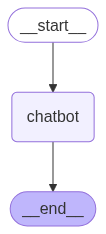

In [39]:
#visualize the graph
from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [40]:
response=graph.invoke({"messages":"hi"})

In [41]:
response["messages"][-1].content#the message is added in a list by the help of the annotation that act as a reducer


'How can I assist you today?'

In [42]:
for event in graph.stream({"messages":"hi how are you?"}):
  for value in event.values():
    print(value["messages"][-1].content)

I'm just a computer program, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have. How can I assist you today?


In [43]:
from langchain_tavily import TavilySearch
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [44]:
tool = TavilySearch(api_key=TAVILY_API_KEY, max_results=2)
tool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by model

In [45]:
def multiply(a:int,b:int)->int:
  """Multiply a and b
  Args:
    a (int): first number
    b (int): second number
    Returns:
      int: output int"""
  return a*b

In [46]:
tools=[tool,multiply]#here we added both the tools(tavily search and multiply function) to a list

In [47]:
llm_with_tools=llm.bind_tools(tools)#here we bind the tools to the llm

In [48]:
#stategraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()#this will save the conversation in memory
#node definition
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}
#GRAPH
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#creating edges(this includes conditional edges)
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
  "tool_calling_llm",
  tools_condition
)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm",END)

graph=builder.compile(checkpointer=memory)#this compiles the graph and implements the logic

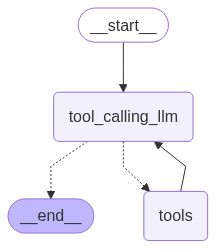

In [49]:
from IPython.display import Image,display
try:   
  display(Image(builder.compile().get_graph().draw_mermaid_png()))
except Exception:
  pass

In [50]:
#creating a config for memory
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"hello,my name is shubham"},config=config)
response["messages"][-1].pretty_print()


================================== Ai Message ==================================

Hello Shubham, it's nice to meet you. How can I assist you today?


In [53]:
response=graph.invoke({"messages":"what is my name as mentioned previously?"},config=config)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name as mentioned previously is Shubham.


##streaming techniques

In [ ]:
config = {"configurable": {"thread_id": "2"}}#why do we need this?---> to create a new thread for a new conversation
for chunk in graph.stream({"messages":"is it possible to make a car faster than speed of light"},config,stream_mode="values"):
  print(chunk)

{'messages': [HumanMessage(content='is it possible to make a car faster than speed of light', additional_kwargs={}, response_metadata={}, id='ccaa7dab-f1f8-491c-a8ce-5f269a7b3ccf')]}
{'messages': [HumanMessage(content='is it possible to make a car faster than speed of light', additional_kwargs={}, response_metadata={}, id='ccaa7dab-f1f8-491c-a8ce-5f269a7b3ccf'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'sr05eybjd', 'function': {'arguments': '{"query":"is it possible to make a car faster than the speed of light","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 1907, 'total_tokens': 1941, 'completion_time': 0.052932938, 'prompt_time': 0.173041026, 'queue_time': 0.050369273, 'total_time': 0.225973964}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a2e965

#Human in the loop

In [94]:
llm=ChatGroq(api_key=GROQ_API_KEY,model="deepseek-r1-distill-llama-70b",temperature=0.7)

In [95]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000231575E0350>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002315757D0D0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [96]:
from langgraph.types import Command,interrupt
#Human in the loop
class State_(TypedDict):
  messages:Annotated[list,add_messages]
graph_builder=StateGraph(State_)

In [97]:
from langchain_core.tools import tool

In [98]:
@tool #tool library used to create a human tool
def human_assistance(query:str)->str:
  """Request assistance from human"""
  human_response=interrupt({"query":query})
  return human_response["data"]

In [99]:
tool = TavilySearch(max_results=2)
tools=[tool,human_assistance]
llm_with_tools=llm.bind_tools(tools)#this is used for binding multiple tools to the llm



In [100]:
#creating the graph

In [101]:
def chatbot(state:State_):
  message=llm_with_tools.invoke(state["messages"])
  return {"messages":[message]}
graph_builder.add_node("chatbot",chatbot)#when we create a node we first assign a name to it then function it will perform
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_edge(START,"chatbot")#when we create an edge we first specify the starting node then the ending node
graph_builder.add_conditional_edges(
  "chatbot",
  tools_condition,
  )
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [102]:
memory=MemorySaver()
graph=graph_builder.compile(checkpointer=memory)

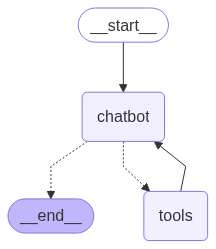

In [103]:
from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [110]:
user_input="what is langgraph?i need some expert guidance and assistance for buildeing an ai agent .could you request assistance for me?"
config ={"configurable":{"thread_id":"1"}}

events=graph.stream(
  {"messages":user_input},
  config,
  stream_mode="values",
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is langgraph?i need some expert guidance and assistance for buildeing an ai agent .could you request assistance for me?
================================== Ai Message ==================================

LangGraph is an AI model developed by Anthropic, designed for a variety of natural language processing tasks, including text generation, summarization, and conversation. It is part of the broader category of large language models (LLMs) like GPT, and it is known for its ability to understand and generate human-like text.

If you're looking to build an AI agent, I can certainly help guide you through the process. However, if you'd like to request expert assistance, here's how you can do it:
Tool Calls:
  human_assistance (25yvqrcek)
 Call ID: 25yvqrcek
  Args:
    query: I need expert guidance and assistance for building an AI agent.


In [111]:
human_response=("Sure, I can help you with that. LangGraph is a powerful framework for building AI agents using state graphs. It allows you to define states, transitions, and actions in a structured way, making it easier to manage complex workflows. If you have any specific questions or need further assistance, feel free to ask!")
human_command=Command(resume={"data":human_response})
events=graph.stream(
  human_command,
  config,
  stream_mode="values"
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

LangGraph is an AI model developed by Anthropic, designed for a variety of natural language processing tasks, including text generation, summarization, and conversation. It is part of the broader category of large language models (LLMs) like GPT, and it is known for its ability to understand and generate human-like text.

If you're looking to build an AI agent, I can certainly help guide you through the process. However, if you'd like to request expert assistance, here's how you can do it:
Tool Calls:
  human_assistance (25yvqrcek)
 Call ID: 25yvqrcek
  Args:
    query: I need expert guidance and assistance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

Sure, I can help you with that. LangGraph is a powerful framework for building AI agents using state graphs. It allows you to define states, transitions, and actions in a s